# Read in the data

In [2]:
import pandas as pd
import numpy
import re

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

# Read in the surveys

In [3]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

# Add DBN columns


In [4]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

In [5]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [6]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [7]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [8]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Add a school district column for mapping

In [9]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations

In [10]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
SAT Writing Avg. Score                  0.987771
sat_score                               1.000000
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Number of Exams with scores 3 4 or 5    0.463245
Total Cohort                            0.325144
CSD                                     0.042948
NUMBER OF STUDENTS / SEATS FILLED       0.394626
NUMBER OF SECTIONS                      0.362673
AVERAGE CLASS SIZE                      0.381014
SIZE OF SMALLEST CLASS                  0.249949
SIZE OF LARGEST CLASS                   0.314434
SCHOOLWIDE PUPIL-TEACHER RATIO               NaN
schoolyear                                   NaN
fl_percent                                   NaN
frl_percent                            -0.722225
total_enrollment                        0.367857
ell_num                                -0.153778
ell_percent         

# Plotting survey correlations

In [11]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")

In [12]:
import matplotlib
%matplotlib inline

In [13]:
print(combined.columns[0:100])

Index(['DBN', 'SCHOOL NAME', 'Num of SAT Test Takers',
       'SAT Critical Reading Avg. Score', 'SAT Math Avg. Score',
       'SAT Writing Avg. Score', 'sat_score', 'SchoolName', 'AP Test Takers ',
       'Total Exams Taken', 'Number of Exams with scores 3 4 or 5',
       'Demographic', 'School Name', 'Cohort', 'Total Cohort',
       'Total Grads - n', 'Total Grads - % of cohort', 'Total Regents - n',
       'Total Regents - % of cohort', 'Total Regents - % of grads',
       'Advanced Regents - n', 'Advanced Regents - % of cohort',
       'Advanced Regents - % of grads', 'Regents w/o Advanced - n',
       'Regents w/o Advanced - % of cohort',
       'Regents w/o Advanced - % of grads', 'Local - n', 'Local - % of cohort',
       'Local - % of grads', 'Still Enrolled - n',
       'Still Enrolled - % of cohort', 'Dropped Out - n',
       'Dropped Out - % of cohort', 'CSD', 'NUMBER OF STUDENTS / SEATS FILLED',
       'NUMBER OF SECTIONS', 'AVERAGE CLASS SIZE', 'SIZE OF SMALLEST CLASS',
  

In [14]:
print(survey_fields)

['rr_s', 'rr_t', 'rr_p', 'N_s', 'N_t', 'N_p', 'saf_p_11', 'com_p_11', 'eng_p_11', 'aca_p_11', 'saf_t_11', 'com_t_11', 'eng_t_11', 'aca_t_11', 'saf_s_11', 'com_s_11', 'eng_s_11', 'aca_s_11', 'saf_tot_11', 'com_tot_11', 'eng_tot_11', 'aca_tot_11']


# Plotting a bar chart of correlations between Sat Score and a series of Surveys.

In [15]:
import matplotlib.pyplot as plt

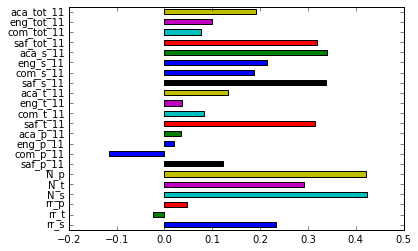

In [16]:
correlations = combined.corr()["sat_score"]
correlations[survey_fields].plot.barh()


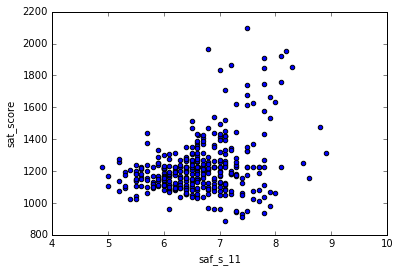

In [17]:
#Plotting the Safety and Respect column vs the SAT score.
combined.plot.scatter("saf_s_11","sat_score")

Seems to suggest largely that safety and respect score has low impact on SAT score.

## Plotting Safety Perception in the New York City Map

In [18]:
school_dist = combined.groupby("school_dist").agg(numpy.mean)

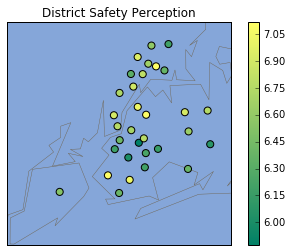

In [19]:
from mpl_toolkits.basemap import Basemap
longitudes = school_dist["lon"].tolist()
latitudes = school_dist["lat"].tolist()

m = Basemap (projection = 'merc', llcrnrlat = 40.496044, urcrnrlat = 40.915256, llcrnrlon = -74.255735, urcrnrlon = -73.700272, resolution = 'i')
m.drawmapboundary(fill_color = '#85A6D9')
m.drawcoastlines(color = '#6D5F47', linewidth =.4)
m.drawrivers(color = '#6D5F47', linewidth =.4)

m.scatter(longitudes, latitudes, s=50, zorder=2, latlon=True, c=school_dist["saf_s_11"], cmap="summer")
plt.title("District Safety Perception")
plt.colorbar()
plt.show()

The above displays the safety perception around the New York school area. Safety perception seems to be lowest around the central parts of brooklyn with the northern parts being marginally safer.

## Race vs SAT scores.

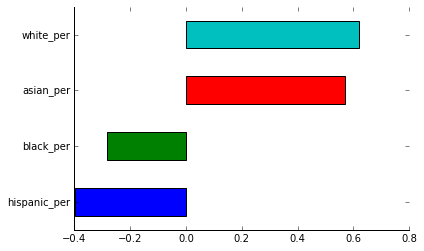

In [20]:
races = ["white_per", "asian_per", "black_per", "hispanic_per"]
ax = correlations[races].sort_values()
ax = ax.plot(kind = "barh")
ax.spines['right'].set_visible(False)
ax.spines["top"].set_visible(False)

The correlation show that students of white and asian perform better than those with black or hispaninc backgrounds. The negative correlation is higher for hispanic than for black students.

There is a higher value of SAT scores for white students than asian students, this is unexpected and often the reverse is true.

## Working out % Hispanic vs SAT

In [21]:
sat_values = combined["sat_score"].value_counts().sort_index()
print(sat_values.head(5))
print(sat_values.tail(5))

887.0    1
913.0    1
934.0    1
939.0    1
945.0    1
Name: sat_score, dtype: int64
1910.0    1
1920.0    1
1953.0    1
1969.0    1
2096.0    1
Name: sat_score, dtype: int64


Assume low SAT level is <=1000 and high is >=1800. Filter for high and low SATs.

     sat_score  hispanic_per
5       1856.0          18.2
37      2096.0           2.4
79      1847.0          21.2
91       945.0          71.8
125      951.0          99.4
126      965.0          72.2
139      962.0          84.7
141      934.0          99.8
151     1969.0           7.2
155     1920.0          18.0
176      970.0          99.8
179      939.0          84.6
187     1833.0           7.9
188      981.0          28.6
225      913.0          27.9
237      963.0           4.5
253      887.0          99.8
286      951.0         100.0
302     1910.0          12.9
327     1868.0           7.9
356     1953.0           5.3


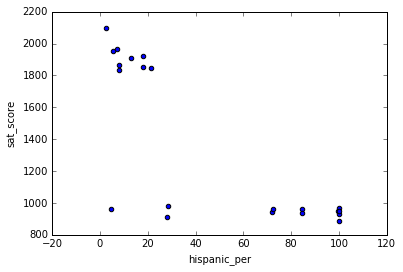

In [29]:
high_low_sats_filter = (combined["sat_score"] <= 1000) | (combined["sat_score"] > 1800 )
high_low_sats_hisp = combined[high_low_sats_filter][["sat_score","hispanic_per"]]
print(high_low_sats_hisp)
high_low_sats_hisp.plot( x = "hispanic_per", y= "sat_score", kind= "scatter")

The graph speaks volumes. Schools with disproportionately high hispanic percentages are worse performing than those with low hispanic percentages (with a few exceptions). Can these exceptions be explained?

In [23]:
sat_low_hisp_low_filter = (combined["sat_score"] <= 1000) & (combined["hispanic_per"] <=40 )
sat_low_hisp_low = combined[sat_low_hisp_low_filter][["SCHOOL NAME","sat_score","white_per","asian_per","hispanic_per", "black_per"]]
print(sat_low_hisp_low)


                                       SCHOOL NAME  sat_score  white_per  \
188             BROOKLYN INTERNATIONAL HIGH SCHOOL      981.0        8.7   
225  INTERNATIONAL HIGH SCHOOL AT PROSPECT HEIGHTS      913.0       14.2   
237                     IT TAKES A VILLAGE ACADEMY      963.0        0.5   

     asian_per  hispanic_per  black_per  
188       42.5          28.6       20.2  
225       28.4          27.9       29.2  
237        1.8           4.5       92.9  


Two of these are international schools with high percentage of english learners so would be expected these would perform lower on the SATs.
The latter, "It takes a village academy", has a very high black percentage which in general have lower SAT scores and could be a factor.

## Investigating very high hispanic percentage schools

In [24]:
hisp_high_filter = (combined["hispanic_per"] >= 95 )
hisp_high = combined[hisp_high_filter][["SCHOOL NAME","sat_score","white_per","asian_per","hispanic_per", "black_per"]]
print(hisp_high)

                                           SCHOOL NAME  sat_score  white_per  \
44                       MANHATTAN BRIDGES HIGH SCHOOL     1058.0        0.0   
82    WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL     1174.0        0.3   
89   GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...     1014.0        0.0   
125                ACADEMY FOR LANGUAGE AND TECHNOLOGY      951.0        0.0   
141              INTERNATIONAL SCHOOL FOR LIBERAL ARTS      934.0        0.0   
176   PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE      970.0        0.0   
253                          MULTICULTURAL HIGH SCHOOL      887.0        0.0   
286             PAN AMERICAN INTERNATIONAL HIGH SCHOOL      951.0        0.0   

     asian_per  hispanic_per  black_per  
44         0.2          99.8        0.0  
82         0.0          96.7        2.3  
89         0.0          99.8        0.0  
125        0.0          99.4        0.6  
141        0.2          99.8        0.0  
176        0.0          99.

All of these schools cater for international students (from Dominican Republic and other spanish speaking countries) 

In [25]:
sat_high_hisp_low_filter = (combined["sat_score"] >= 1800) & (combined["hispanic_per"] <=10 )
sat_high_hisp_low = combined[sat_high_hisp_low_filter][["SCHOOL NAME","sat_score","white_per","asian_per","hispanic_per", "black_per"]]
print(sat_high_hisp_low)

                                           SCHOOL NAME  sat_score  white_per  \
37                              STUYVESANT HIGH SCHOOL     2096.0       23.7   
151                       BRONX HIGH SCHOOL OF SCIENCE     1969.0       25.4   
187                     BROOKLYN TECHNICAL HIGH SCHOOL     1833.0       21.3   
327  QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...     1868.0        6.7   
356                STATEN ISLAND TECHNICAL HIGH SCHOOL     1953.0       61.3   

     asian_per  hispanic_per  black_per  
37        72.1           2.4        1.2  
151       63.5           7.2        3.5  
187       60.3           7.9       10.2  
327       74.4           7.9       10.5  
356       31.8           5.3        1.1  


These schools are all part of the NYC's 'specialised high schools' for students that 'excel academically or artistically'.

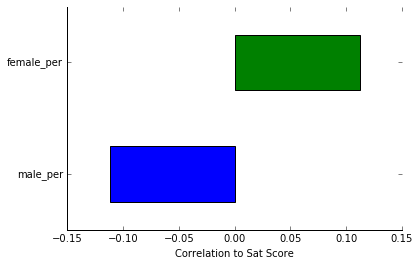

In [35]:
gender = ["male_per", "female_per"]
ax2 = correlations[gender].sort_values()
ax2 = ax2.plot(kind = "barh")
ax2.set_xlabel("Correlation to Sat Score")
ax2.spines['right'].set_visible(False)
ax2.spines["top"].set_visible(False)

plt.show()

Female percentage is positively correlated with higher SAT scores. 
Male percentage is negatively correlated with higher SAT scores.
Hence in general schools with more female than male students perform better in the SATs.
But this correaltion is only ~0.1 which is a weak correlation.

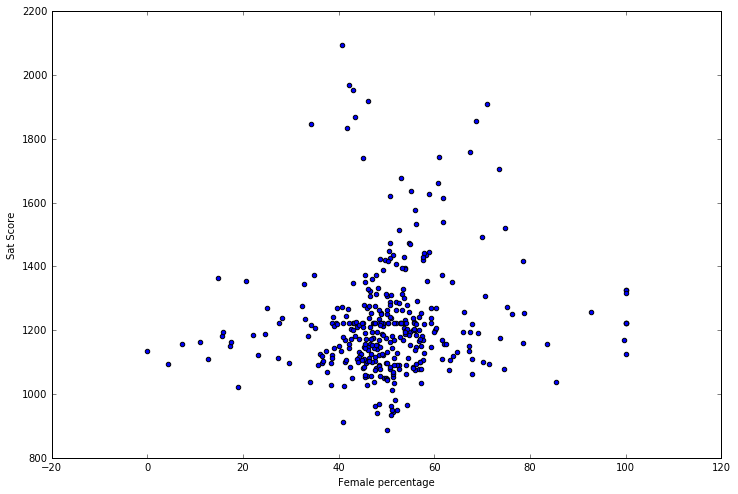

In [27]:
ax = combined.plot.scatter(x="female_per", y="sat_score", figsize=(12,8))
ax.set_xlabel("Female percentage")
ax.set_ylabel("Sat Score")
plt.show()

The graph is nebulous with no specific trend. High and low female percentages seem to have average performance in the SATs. SAT scores above 1500 have between 35 and 80% female students.

In [28]:
sat_high_female_high_filter = (combined["sat_score"] >= 1700) & (combined["female_per"] >=60 )
sat_high_female_high = combined[sat_high_female_high_filter][["SCHOOL NAME","sat_score","white_per","asian_per","hispanic_per", "black_per"]]
print(sat_high_female_high)


                                           SCHOOL NAME  sat_score  white_per  \
5                       BARD HIGH SCHOOL EARLY COLLEGE     1856.0       49.8   
26                       ELEANOR ROOSEVELT HIGH SCHOOL     1758.0       63.7   
60                                  BEACON HIGH SCHOOL     1744.0       49.8   
61   FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...     1707.0       49.2   
302                        TOWNSEND HARRIS HIGH SCHOOL     1910.0       24.6   

     asian_per  hispanic_per  black_per  
5         15.1          18.2       15.1  
26        17.2          11.6        5.5  
60         8.9          22.8       14.6  
61        19.6          16.6       12.9  
302       55.5          12.9        5.9  


Fiorello H Laguardia is on the list of exceptional schools for artistic students.
The others similarly seem to be arts schools.

## Exploring correlation between Advanced Placement (AP) exams and SAT scores

In [42]:
combined["ap_per"] = (combined["AP Test Takers "] / combined["total_enrollment"])
print(combined[["AP Test Takers ", "total_enrollment", "ap_per"]].head())

   AP Test Takers   total_enrollment    ap_per
0       129.028846               422  0.305756
1        39.000000               394  0.098985
2        19.000000               598  0.031773
3       129.028846               367  0.351577
4       255.000000              1613  0.158091


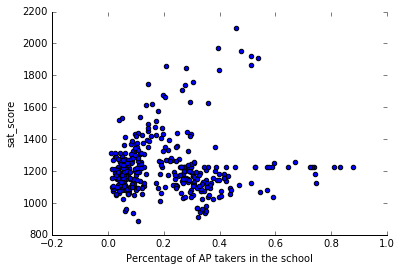

In [47]:
ax3 = combined.plot.scatter(x="ap_per", y="sat_score")
ax3.set_xlabel("Percentage of AP takers in the school")
ax3.spines["right"].set_visible(False)
ax3.spines["top"].set_visible(False)
plt.show()

In general there is no trend.

It almost looks like there are two trends, one showing a positive linear relationship and the other showing no relationship at all. 

The highest of percentage AP takers seem to show no increase in SAT scores at all. We should investigate why.

In [49]:
ap_high_filter = (combined["ap_per"] >= 0.7)
ap_high = combined[ap_high_filter][["SCHOOL NAME","sat_score","white_per","asian_per","hispanic_per", "black_per"]]
print(ap_high)

                                           SCHOOL NAME    sat_score  \
6    47 THE AMERICAN SIGN LANGUAGE AND ENGLISH SECO...  1182.000000   
31               MANHATTAN ACADEMY FOR ARTS & LANGUAGE  1223.438806   
33           INTERNATIONAL HIGH SCHOOL AT UNION SQUARE  1223.438806   
83           HIGH SCHOOL FOR EXCELLENCE AND INNOVATION  1223.438806   
111                          BRONX BRIDGES HIGH SCHOOL  1223.438806   
208                            FRANCES PERKINS ACADEMY  1122.000000   
222             THE BROOKLYN ACADEMY OF GLOBAL FINANCE  1223.438806   
335                            CAMBRIA HEIGHTS ACADEMY  1223.438806   

     white_per  asian_per  hispanic_per  black_per  
6          6.3        1.7          59.2       32.2  
31         1.1        6.3          84.6        8.0  
33         3.4       40.3          43.2       12.5  
83         0.0        0.0          72.5       25.8  
111        2.6        5.2          83.2        8.4  
208        4.0        0.0          31.2   

These schools are specialist schools designed for international students, students with disabilities or students who require additional years to complete school.

## Exploring relationship between class size and SAT scores

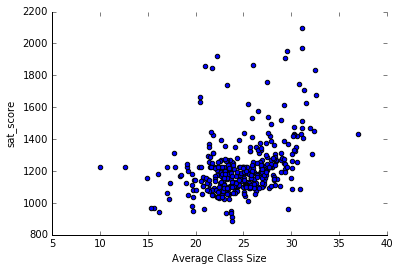

In [51]:
ax4 = combined.plot.scatter(x="AVERAGE CLASS SIZE", y="sat_score")
ax4.set_xlabel("Average Class Size")
ax4.spines["right"].set_visible(False)
ax4.spines["top"].set_visible(False)
plt.show()

Schools with small class sizes often report that this is good for the development of the student. 
The graph shows this claim is not supported. 
Lets review class sizes that are below 15 and above 35 to see what we can learn

In [58]:
class_size_high_and_low_filter = (combined["AVERAGE CLASS SIZE"] <= 15) | (combined["AVERAGE CLASS SIZE"] >= 35)
class_size_high_and_low  = combined[class_size_high_and_low_filter ][["AVERAGE CLASS SIZE","SCHOOL NAME","sat_score","white_per","asian_per","hispanic_per", "black_per","female_per","male_per"]]
print(class_size_high_and_low )

     AVERAGE CLASS SIZE                                     SCHOOL NAME  \
8             14.900000                            ESSEX STREET ACADEMY   
17            37.023077                                     NYC ISCHOOL   
56            10.000000     THE URBAN ASSEMBLY SCHOOL FOR GREEN CAREERS   
264           12.575000  THE URBAN ASSEMBLY SCHOOL FOR CRIMINAL JUSTICE   

       sat_score  white_per  asian_per  hispanic_per  black_per  female_per  \
8    1156.000000        7.6        4.1          60.6       27.7        46.6   
17   1435.000000       24.0       11.5          43.0       20.6        51.3   
56   1223.438806        1.8        1.8          76.0       19.8        43.1   
264  1223.438806        9.1       35.0          21.9       33.7       100.0   

     male_per  
8        53.4  
17       48.7  
56       56.9  
264       0.0  


The above schools in general tend to be progressive, teaching curriculum that deviates from the mainstream. 
This could explain why their SAT grades are average.
In summary though a class size is no indicator of how well the students perform in the SATs.

## Investigating Teacher ,Student and Parent Surveys

The following are the column names for the survey responses:

Response rates:rr_t (for teachers), rr_s (for students), rr_p (for parents)

Safety and respect scores: saf_tot_11

Communication scores: com_tot_11

Engagement scores: eng_tot_11

Academic scores; aca_tot_11


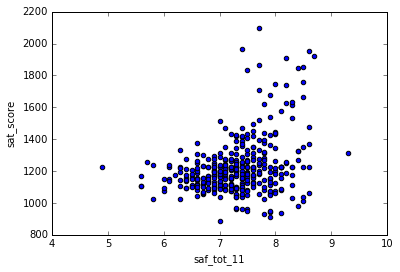

In [67]:
ax5 = combined.plot.scatter(x="saf_tot_11", y="sat_score")
plt.show()

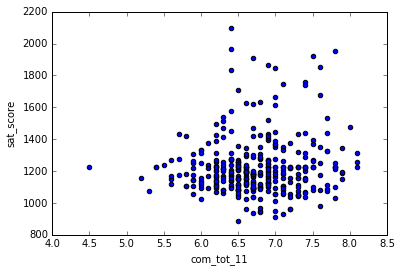

In [68]:
ax5 = combined.plot.scatter(x="com_tot_11", y="sat_score")
plt.show()

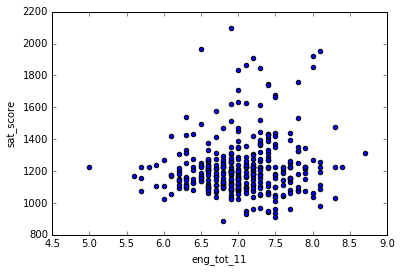

In [69]:
ax5 = combined.plot.scatter(x="eng_tot_11", y="sat_score")
plt.show()

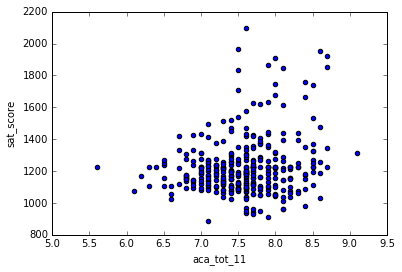

In [70]:
ax5 = combined.plot.scatter(x="aca_tot_11", y="sat_score")
plt.show()

The strongest correlation is safety score with SAT. 

There is a weak positive correlation with the Academic Expectations survey and the actual SAT performance

# Conclusion

The highest performing schools tend to be:
High percentage white, asian (or both).
Highest perceived safety and to some degree academic expectations
A high percentage of native english speakers

What is not an indication of high performing schools alone?
Percentage of students taking AP exams.
Engagement or Communication survey scores.
Percentage of female (or male) students.
Class size